In [1]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import EllipseCollection

from matplotlib.widgets import Slider
# from matplotlib.colors import LinearSegmentedColormap
# import matplotlib.animation as animation
plt.style.use(['dark_background'])



# from collections import Counter
from tqdm import tqdm

In [2]:
def gen_hex_grid(nx,ny, phase = 0):
    '''
    Generate a hexagonal grid of cells on [-1,1]
    '''
    x = np.linspace(-1,1,nx)
    y = np.linspace(-1,1,ny)
    dx = 1./(nx-1)

    X,Y = np.meshgrid(x,y)
    for y in range(phase,ny,2):
        X[y] += dx 

    # want to drop every 10th spot
    #   i.e., nx*2
    X,Y = X.flatten(), Y.flatten()
    X = np.delete(X, np.arange(nx*(1+phase)-1,nx*ny, nx*2))
    Y = np.delete(Y, np.arange(nx*(1+phase)-1,nx*ny, nx*2))
    

    return X,Y

In [3]:
def get_coverage(rf_widths, rf_spacing):
    #inputs are diameters

    return (3*np.pi/4*rf_widths**2) / (3 * np.sqrt(3) / 2 * rf_spacing**2)

In [4]:
def get_response(stim_pos, rf_centers, center_widths, surround_widths, surround_strength):#, SNR):
    '''
    Stimulus position is (2,K)
    RF centers are (2,N)
    RF widths are (N,)
    SNR is (N,)
    '''

    K = stim_pos.size // 2
    N = rf_centers.size // 2

    #z_c: the normalized distance from the RF center; shape (N,K)
    z = np.linalg.norm(stim_pos.reshape((2,1,-1)) - rf_centers.reshape((2,-1,1)), axis=0)
    
    z_c = z / center_widths.reshape((-1,1))
    z_s = z / surround_widths.reshape((-1,1))
    
    # we want the peak to be 1
    # a*x_c - b*x_s
    # suppose f=.1
    # then we need a = (1+f), b=f

    signal = (1+surround_strength)*np.exp(-(z_c**2) / 2) - surround_strength*np.exp(-(z_s**2) / 2)

    return signal
    # return signal


In [5]:
def gauss2(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    # x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((xy[0]-xo)**2) + 2*b*(xy[0]-xo)*(xy[1]-yo) 
                            + c*((xy[1]-yo)**2)))
    return g.ravel()

In [16]:
def sim(rf_centers, center_width, surround_width, surround_strength, SNR, stim_pos, stimulus_range, X=None, Y=None):
    # nr = np.linalg.norm(np.asarray(stim_pos).reshape((2,1,-1)) - rf_centers.reshape((2,-1,1)), axis=0) / (rf_width / 4)

    
    # target = np.exp(-(nr**2) / 2) # / (2*np.pi) #normalization///
    target = get_response(np.asarray(stim_pos), rf_centers, np.asarray(center_width/4), np.asarray(surround_width/4), surround_strength)

    if X is None or Y is None:
        X,Y = np.meshgrid(stimulus_range,stimulus_range)
    

    signal = get_response(np.stack((X.flatten(), Y.flatten())), rf_centers, np.asarray(center_width/4), np.asarray(surround_width/4), surround_strength)

    diff = target - signal
    #N-by-k

    prob = np.prod(norm.pdf(diff, scale=1/SNR), axis=0) #TODO: mvnrand

    return prob,target

In [6]:
x,y = gen_hex_grid(2,2, phase=1)

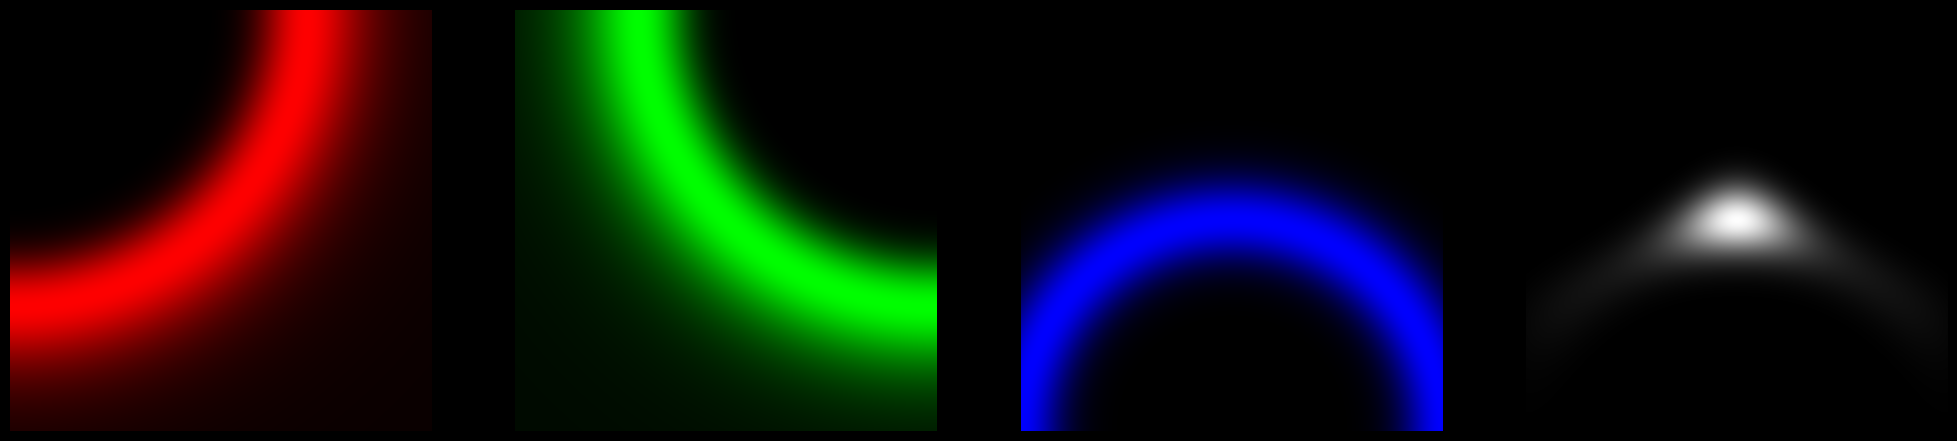

In [72]:
_,axs = plt.subplots(1,4,figsize=(25,7))

stim_range =  np.linspace(-3,3,1000)
cw = 3
sw = 2.5
z = np.zeros((len(stim_range), len(stim_range)))
o = np.ones((len(stim_range), len(stim_range)))


prob, target = sim(np.stack((x[0],y[0])), cw, sw, .9, 10, np.asarray([0,0]), stim_range)
prob = prob - prob.min()
prob = prob / prob.max()
# axs[0].imshow(np.stack((prob.reshape(len(stim_range), len(stim_range)), z, z), axis=-1))
# axs[0].imshow(o, alpha=prob.reshape(len(stim_range), len(stim_range)), cmap='Reds')
axs[0].imshow(np.stack((o, z, z, prob.reshape(len(stim_range), len(stim_range))), axis=-1))
axs[0].axis('off')

a = prob.reshape(len(stim_range), len(stim_range))

prob, target = sim(np.stack((x[1],y[1])), cw, sw, .9, 10, np.asarray([0,0]), stim_range)
prob = prob / prob.max()
axs[1].imshow(np.stack((z, o, z, prob.reshape(len(stim_range), len(stim_range))), axis=-1))
axs[1].axis('off')

b = prob.reshape(len(stim_range), len(stim_range))


prob, target = sim(np.stack((x[2],y[2])), cw, sw, .9, 10, np.asarray([0,0]), stim_range)
prob = prob / prob.max()
axs[2].imshow(np.stack((z, z, o, prob.reshape(len(stim_range), len(stim_range))), axis=-1))
axs[2].axis('off')

c = prob.reshape(len(stim_range), len(stim_range))

# axs[3].imshow(prob.reshape(len(stim_range), len(stim_range)), cmap='gray')
# axs[3].imshow(np.stack((a,b,c), axis=-1), cmap='gray')

axs[3].imshow(np.stack((o, o, o, a*b*c), axis=-1))
# axs[3].imshow(a*b*c, cmap='gray')


# prob, target = sim(np.stack((x,y)), cw, sw, .9, 10, np.asarray([0,0]), stim_range)
# axs[3].imshow(prob.reshape(len(stim_range), len(stim_range)), cmap='gray')
# plt.colorbar()
plt.axis('off')
plt.savefig(r'C:\Users\zfj\Downloads\test.svg', transparent=True)

27

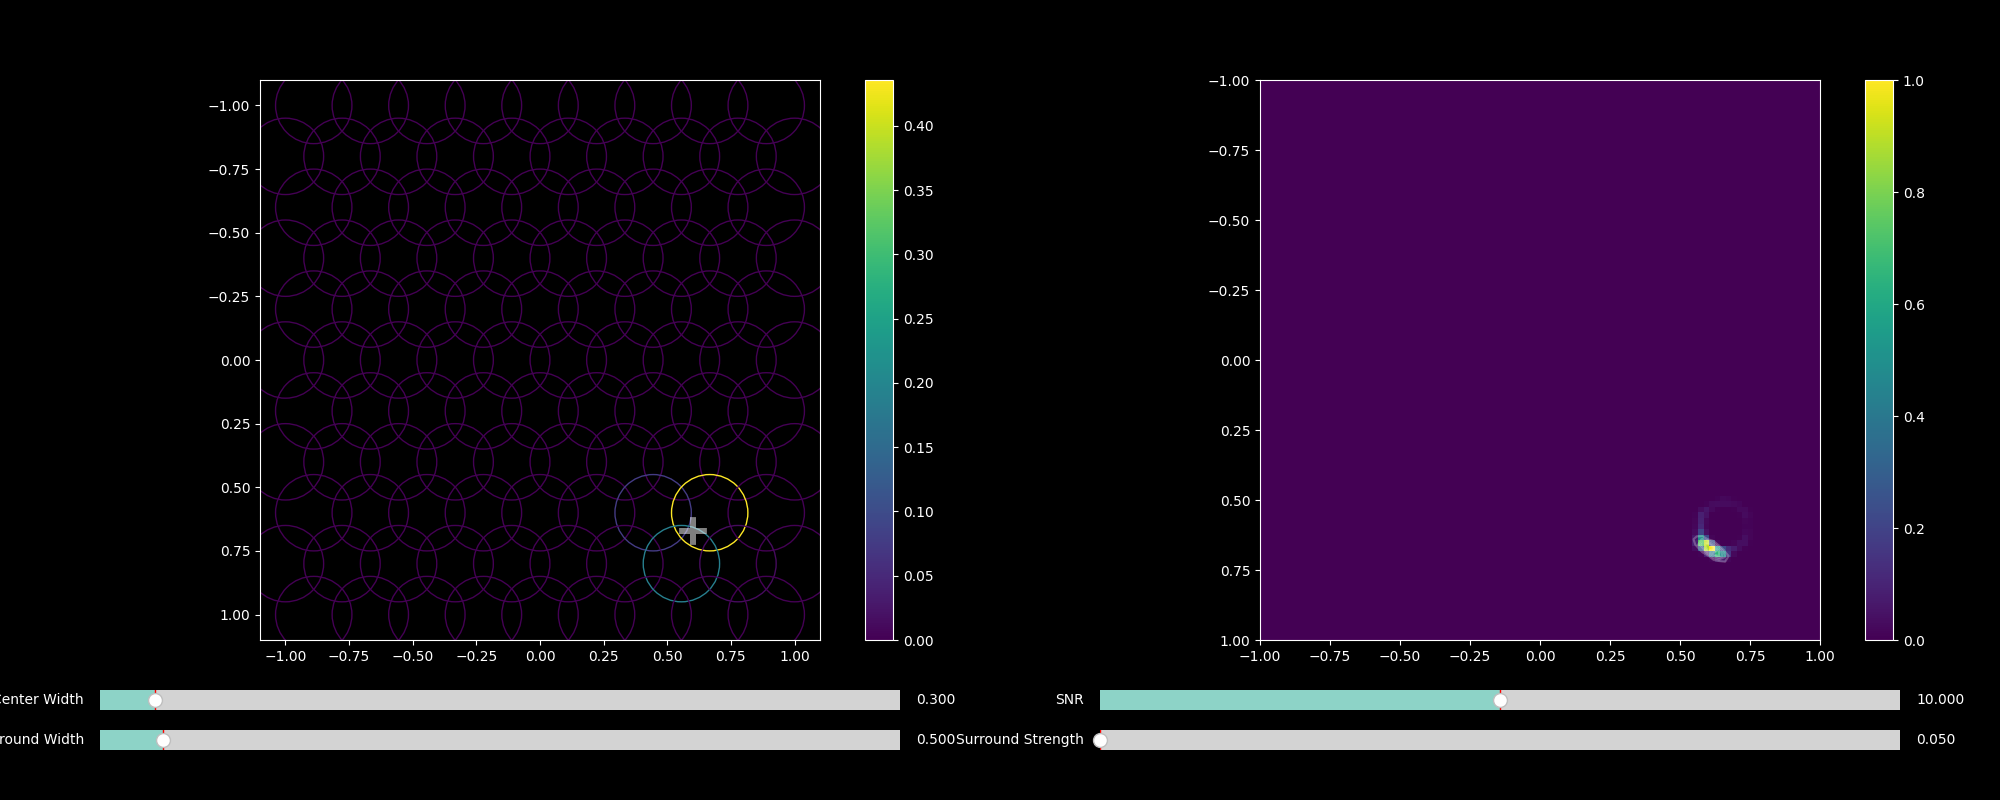

In [ ]:
# %matplotlib widget
def fit(rf_centers, cw, sw, ss, SNR, stim_pos, X, Y):
    N_s, sig = sim(rf_centers, cw, sw, ss, SNR, stim_pos, None, X=X, Y=Y)
    N_s = N_s.reshape(X.shape)
    N_s = N_s / N_s.max()

    cy,cx = xyrange[np.argwhere(N_s == 1)[0]]    

    
    N_x = N_s.mean(axis=0)
    sx = np.count_nonzero(N_x > N_x.max()/2) / len(xyrange) * (xyrange[-1] - xyrange[0])

    N_y = N_s.mean(axis=1)
    sy = np.count_nonzero(N_y > N_y.max()/2) / len(xyrange) * (xyrange[-1] - xyrange[0])

    try:
        popt, _ = curve_fit(gauss2, (X.flatten(), Y.flatten()), N_s.flatten(), p0=(1.0,cx,cy,sx,sy,0,0), maxfev=10000)
        f = gauss2((X,Y), *popt)
    except RuntimeError:
        f = None

    return N_s, f, sig


xyrange = np.linspace(-1,1,101)
X,Y = np.meshgrid(xyrange, xyrange)
rf_centers = np.stack((x,y))
cw = .3
sw = .5
ss = 0.0#.1
stim_pos = (.6, .67)
SNR = 10

plt.close('all')
# fig, axs = plt.subplots(1,2,figsize=(20,13))
fig = plt.figure(figsize=(20,8))
axs = []
axs.append(fig.add_axes([.05,.2,.45,.7]))
axs.append(fig.add_axes([.55,.2,.45,.7]))
# axs = axs.flatten()
    
N_s, f, sig = fit(rf_centers, cw, sw, ss, SNR, stim_pos, X,Y)
# sc = axs[0].scatter(*rf_centers,c=sig)
# n = mpl.colors.Normalize(vmin = min(sig), vmax = max(sig))
# m = mpl.cm.ScalarMappable(norm=n, cmap='magma')
sc = EllipseCollection(offsets = rf_centers.T, widths = cw, heights = cw, angles=0, units='xy', offset_transform=axs[0].transData, facecolors='None')#, facecolors='None', edgecolors=sig)
sc.set_array(sig[:,0])
axs[0].add_collection(sc)

axs[0].axis('square')
# axs[0].set_xlim([-1.1, 1.1])
# axs[0].set_ylim([-1.1, 1.1])

p0 = axs[0].plot(*stim_pos, marker='+', mew=20, ms=5, color='w', alpha=.5)
axs[0].invert_yaxis()

# p1 = axs[1].plot(*stim_pos, marker='+', mew=20, ms=5, color='w', alpha=.5)

im = axs[1].imshow(N_s, extent=(xyrange[0],xyrange[-1],xyrange[-1],xyrange[0]))
ct = axs[1].contour(X,Y, f.reshape(X.shape), 8, colors='w', alpha=.25)

cb1 = fig.colorbar(sc, ax=axs[0])
fig.colorbar(im, ax=axs[1])

# print(sc)



wax = fig.add_axes([.05, .1, .4, .05])
sax = fig.add_axes([.55, .1, .4, .05])

swax = fig.add_axes([.05, .05, .4, .05])
scax = fig.add_axes([.55, .05, .4, .05])

w_slider = Slider(
    ax=wax,
    label='Center Width',
    valmin=.1,
    valmax=3,
    valinit=cw,
    valfmt='%0.03f'
)
snr_slider = Slider(
    ax=sax,
    label='SNR',
    valmin=-1,
    valmax=3,
    valinit=np.log10(SNR),
    # valfmt='%0.0f'
)
snr_slider.valtext.set_text(f'{SNR:0.03f}')

sw_slider = Slider(
    ax=swax,
    label='Surround Width',
    valmin=.2,
    valmax=4,
    valinit=sw,
    valfmt='%0.03f'
)

sc_slider = Slider(
    ax=scax,
    label='Surround Strength',
    valmin=.05,
    valmax=.9,
    valinit=ss,
    valfmt='%0.03f'
)

def redraw():
    global ct
    global sc
    N_s, f, sig = fit(rf_centers, cw, sw, ss, SNR, stim_pos, X,Y)
    
    sc.remove()
    # sc = axs[0].scatter(*rf_centers,c=sig)
    sc = EllipseCollection(offsets = rf_centers.T, widths = cw, heights = cw, angles=0, units='xy', offset_transform=axs[0].transData, facecolors='None')#, facecolors='None', edgecolors=sig)
    sc.set_array(sig[:,0])
    axs[0].add_collection(sc)


    p0[0].set_data([stim_pos[0]], [stim_pos[1]])
    # p1[0].set_data([stim_pos[0]], [stim_pos[1]])
    im.set_data(N_s)
    if ct is not None:
        for coll in ct.collections:        
            coll.remove()
            ct = None
    if f is not None:
        ct = axs[1].contour(X,Y, f.reshape(X.shape), 8, colors='w', alpha=.25)

    

def onclick(event):
    global stim_pos
    if event.inaxes == axs[0] or event.inaxes == axs[1]:
        stim_pos = (event.xdata, event.ydata)
        redraw()

def update_snr(_):
    global SNR
    SNR = 10 ** snr_slider.val
    snr_slider.valtext.set_text(f'{SNR:0.02f}')
    redraw()

def update_w(_):
    global cw
    cw =  w_slider.val
    redraw()

def update_sw(_):
    global sw
    sw =  sw_slider.val
    redraw()

def update_ss(_):
    global ss
    ss =  sc_slider.val
    redraw()

snr_slider.on_changed(update_snr)
w_slider.on_changed(update_w)
sw_slider.on_changed(update_sw)
sc_slider.on_changed(update_ss)

fig.canvas.mpl_connect('button_press_event', onclick)

In [131]:
# for w, snr
    #for true_stim_pos in range:
        # generate_prob_map
        # normalize to sum 1 over (-1,1)X(-1,1)
        # convert to cdf over distance from true_stim_pos
        # append(where(cdf == 0.5))
    #get mean, std over range
ws = np.linspace(0.2, 1.0, 20)
snrs = np.logspace(-1, 3, 20)

rf_centers = np.stack((x,y))
testrange = np.linspace(-2,2,101)
X,Y = np.meshgrid(testrange, testrange)

stimrange = np.linspace(-0.5,0,5,11)
sX,sY = np.meshgrid(stimrange, stimrange)

d = np.empty(sX.size)

mu = np.empty((len(ws), len(snrs))) * np.nan
sig = np.empty_like(mu) * np.nan

with tqdm(total=mu.size) as pbar:
    for i,w in enumerate(ws):
        for j,snr in enumerate(snrs):
            for k,(sx,sy) in enumerate(zip(sX.flatten(), sY.flatten())):
                prob,_ = sim(rf_centers, w, snr, (sx, sy), None, X=X, Y=Y)
                prob /= prob.sum()
                r = ((X - sx)**2 + (Y-sy)**2).flatten()
                ri = np.argsort(r)
                pi = np.nonzero(np.cumsum(prob[ri])>.5)[0]
                if len(pi):
                    d[k] = r[ri][pi[0]]
                else:
                    # print('!', w, snr, (sx,sy))
                    d[k] = np.nan
            mu[i,j] = np.nanmean(d)
            sig[i,j] = np.nanstd(d)
            pbar.update()




  4%|▍         | 18/400 [00:40<13:45,  2.16s/it]C:\Users\zfj\AppData\Local\Temp\ipykernel_30524\4122711095.py:28: RuntimeWarning: invalid value encountered in true_divide
  prob /= prob.sum()
100%|██████████| 400/400 [12:05<00:00,  1.81s/it]


(0.16, 1.04) [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1]


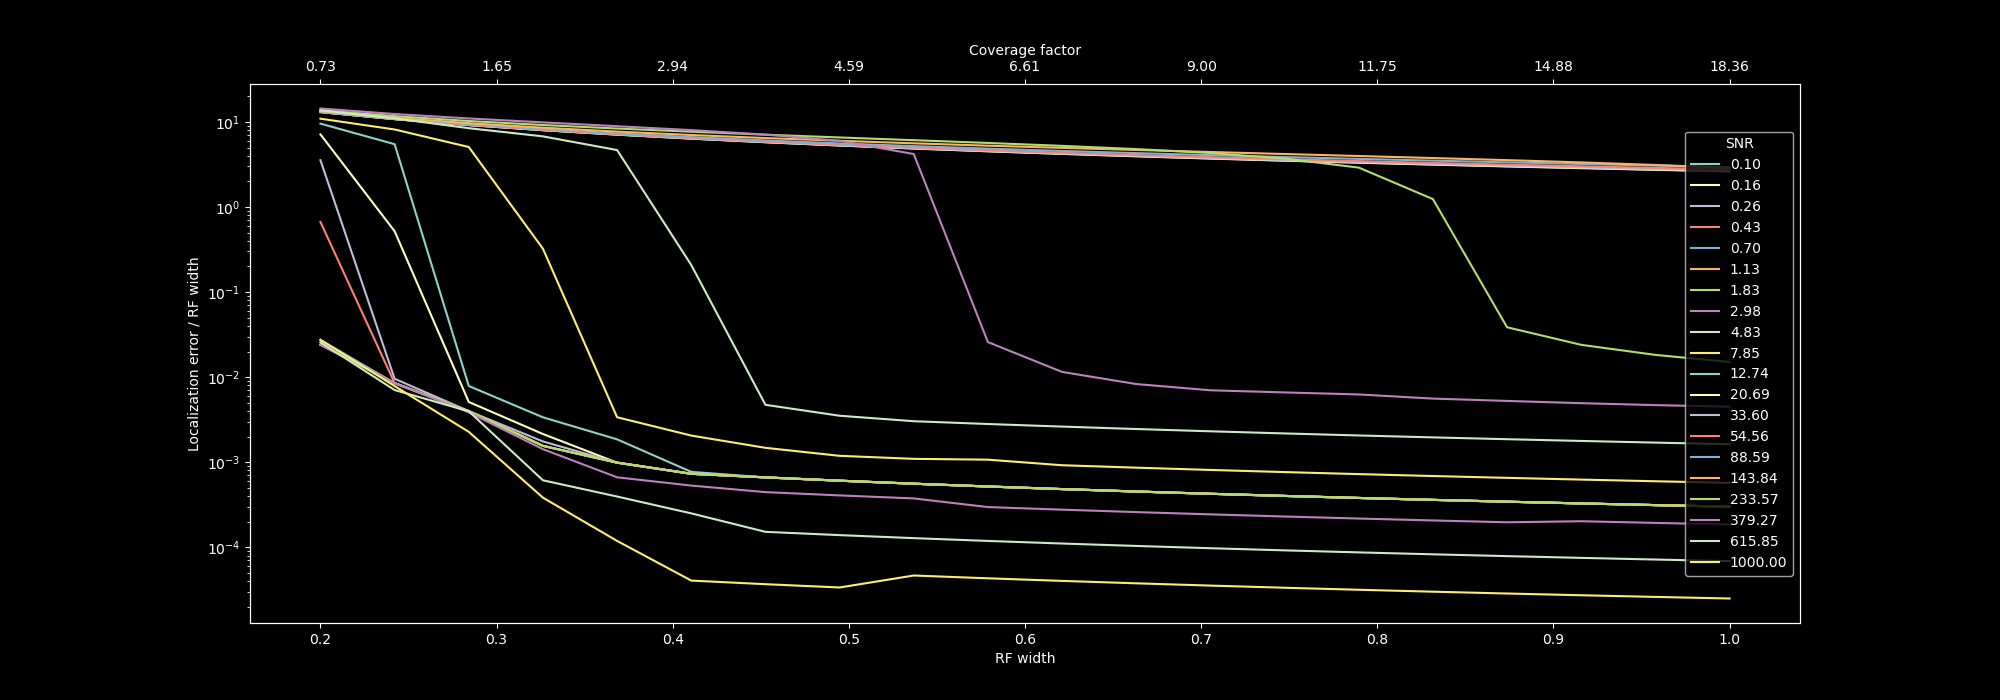

In [132]:
plt.close('all')
# _,axs = plt.subplots(2,1,figsize=(20,13))
_,axs = plt.subplots(1,1,figsize=(20,7))

# plt.sca(axs[0])
# for j,snr in enumerate(snrs):
#     plt.plot(get_coverage(ws, 2/9), mu[:,j] / ws, label=snr)
# plt.legend(loc='right', title='SNR')

# plt.yscale('log')
# plt.xlabel('Coverage factor')
# plt.ylabel('Localization error / RF width')

# plt.sca(axs[1])
for j,snr in enumerate(snrs):
    # plt.plot(ws, mu[:,j] / ws, label=f"{snr:0.2e}")
    plt.plot(ws, mu[:,j] / ws, label=f"{snr:0.2f}")
plt.legend(loc='right', title='SNR')

plt.yscale('log')
plt.xlabel('RF width')
plt.ylabel('Localization error / RF width')
xl, xt = plt.xlim(), plt.xticks()[0]

print(xl, xt)
plt.twiny()
# plt.xlim(get_coverage(np.asarray(xl), 2/9))
plt.xticks(ticks=xt, labels=[f"{get_coverage(xtt, 2/9):0.02f}" for xtt in xt])
plt.xlabel('Coverage factor')
plt.xlim(xl)
plt.show()

Text(0.5, 0.98, 'SNR = 2.98')

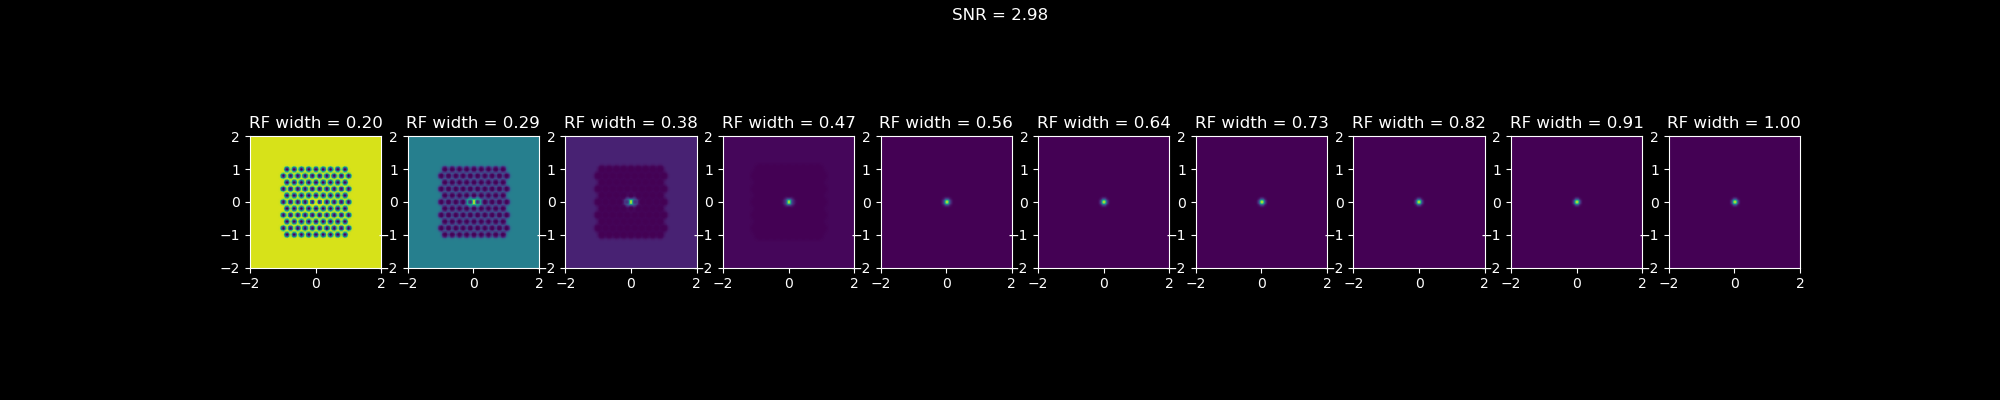

In [161]:
plt.close('all')
ncols = 10
_,axs = plt.subplots(1,ncols, figsize=(20,4))
for i,w in enumerate(np.linspace(0.2, 1.0, ncols)):
    prob,_ = sim(rf_centers, w, 2.98, (0,0), None, X=X, Y=Y)
    prob /= prob.sum()
    im = axs[i].imshow(prob.reshape(X.shape), extent=[-2,2,-2,2])
    axs[i].set_title(f'RF width = {w:0.02f}')
    # im.set_clim(0.0001,0.05)

    # print(im.get_clim())

    # prob,_ = sim(rf_centers, w, snr, stim_pos, (sx, sy), X=X, Y=Y)
plt.gcf().suptitle(f"SNR = 2.98")
                